# Natural Images Classification Using CNN

## Environment Setup and Import Modules

In [ ]:
!pip install tensorflow

### Load and Prepare Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
data_dir = '/content/drive/MyDrive/ColabNotebooks/CECS456/FinalProject/project_images/natural_images'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
data_dir = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
# train dataframe
train_df, dummy_df = train_test_split(data_dir,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [ ]:
# resized images
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5575 validated image filenames belonging to 8 classes.
Found 836 validated image filenames belonging to 8 classes.
Found 558 validated image filenames belonging to 8 classes.


## Samples from Training Data

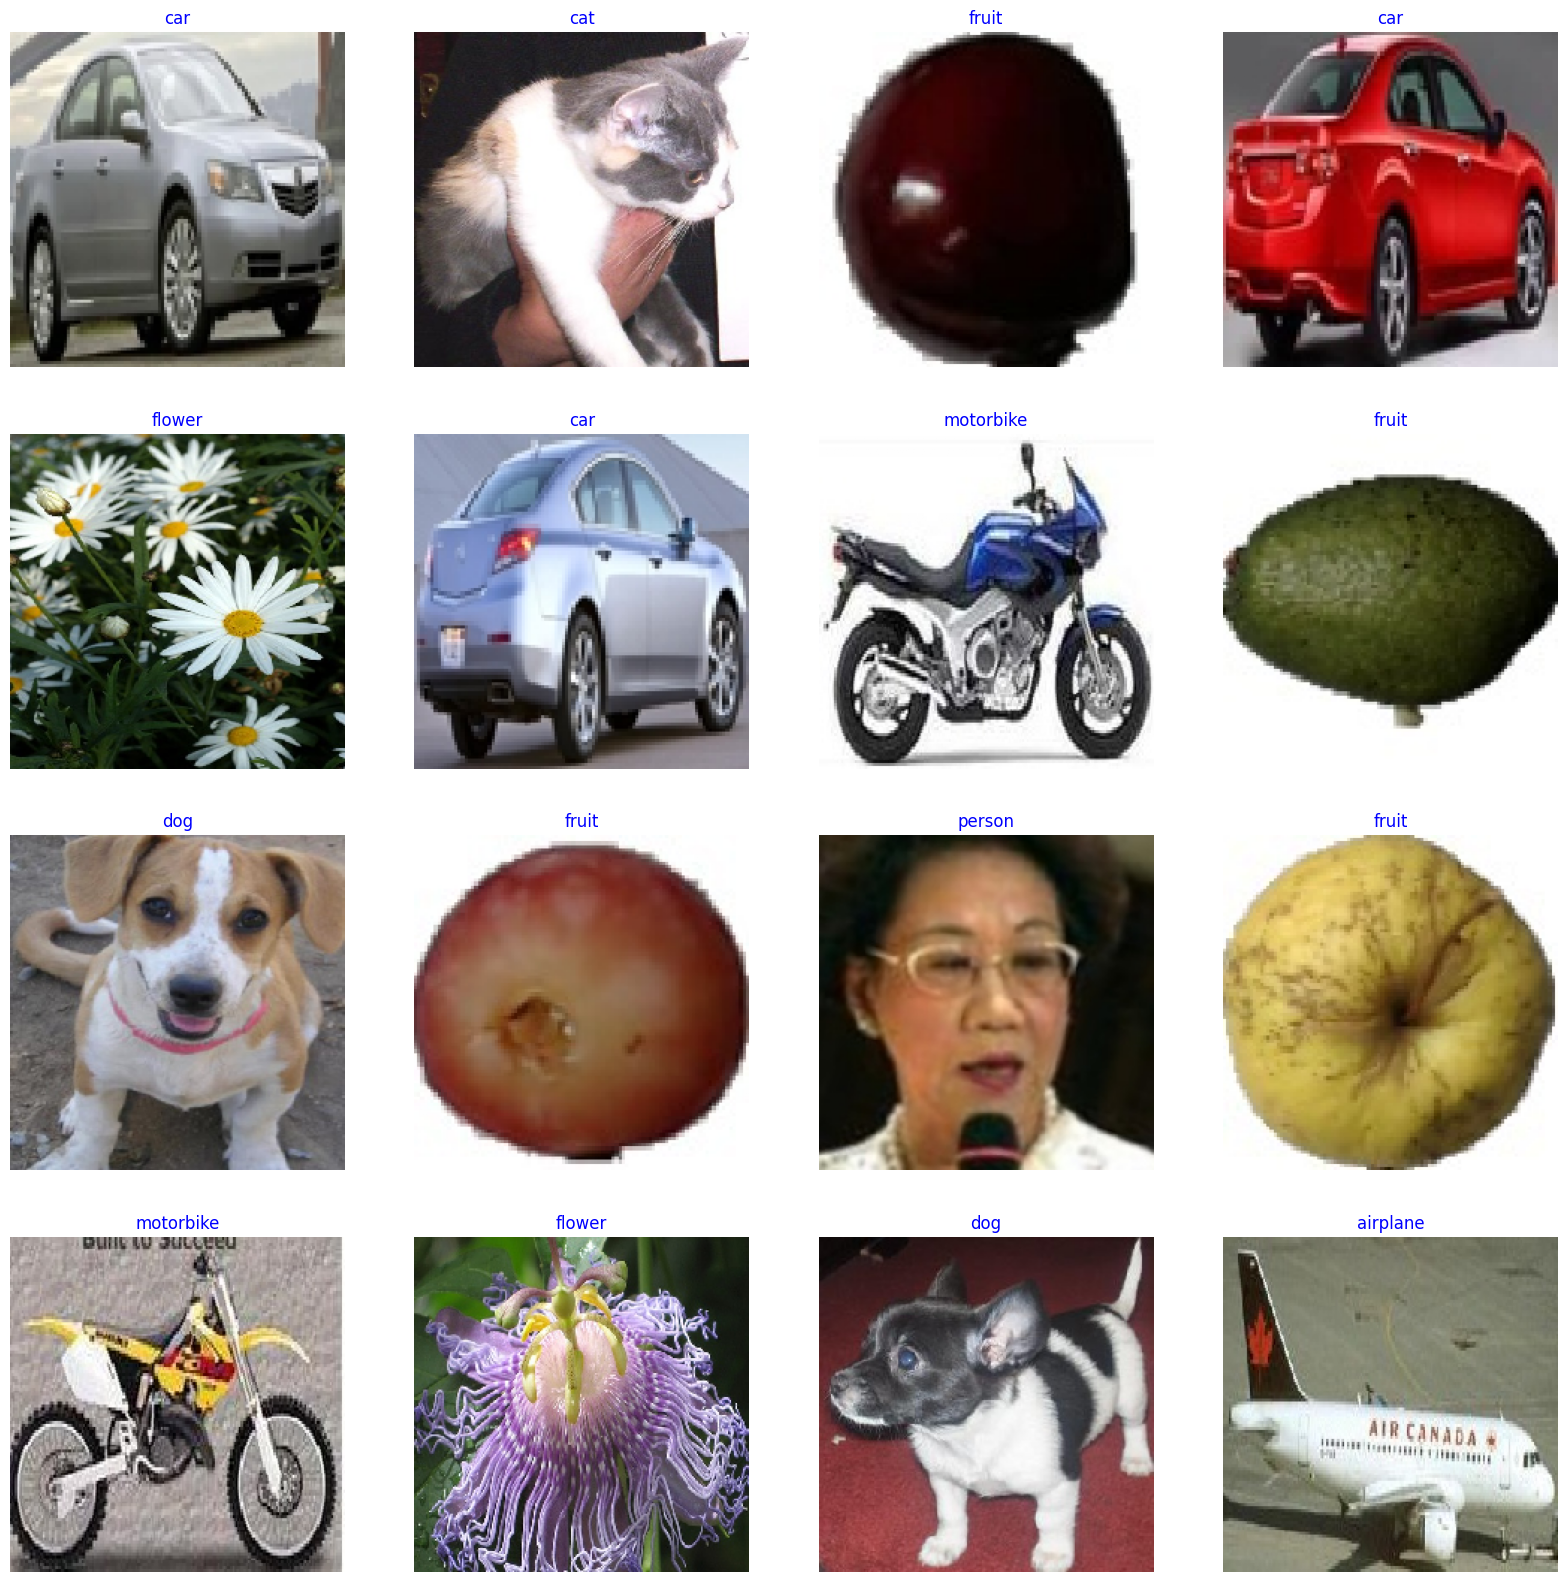

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())         # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

## Model Build

In [ ]:
def build_model(input_shape, num_classes):
    model = Sequential([
        # First convolutional layer
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Second convolutional layer
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Third convolutional layer
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Flattening the 3D output to 1D
        Flatten(),

        # Dense layer
        Dense(128, activation='relu'),
        Dropout(0.5),

        # Output layer
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create Model Structure
img_size = (224, 224)
channels = 3
input_shape = (img_size[0], img_size[1], channels)
num_classes = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# Build the model
model = build_model(input_shape, num_classes)

# Model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 64)      256       
 chNormalization)                                                
                                                        

## Training the Model

In [1]:
# Training the model
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=valid_gen,
    validation_steps=None)


NameError: name 'model' is not defined

## Model Loss and Accuracy Performance

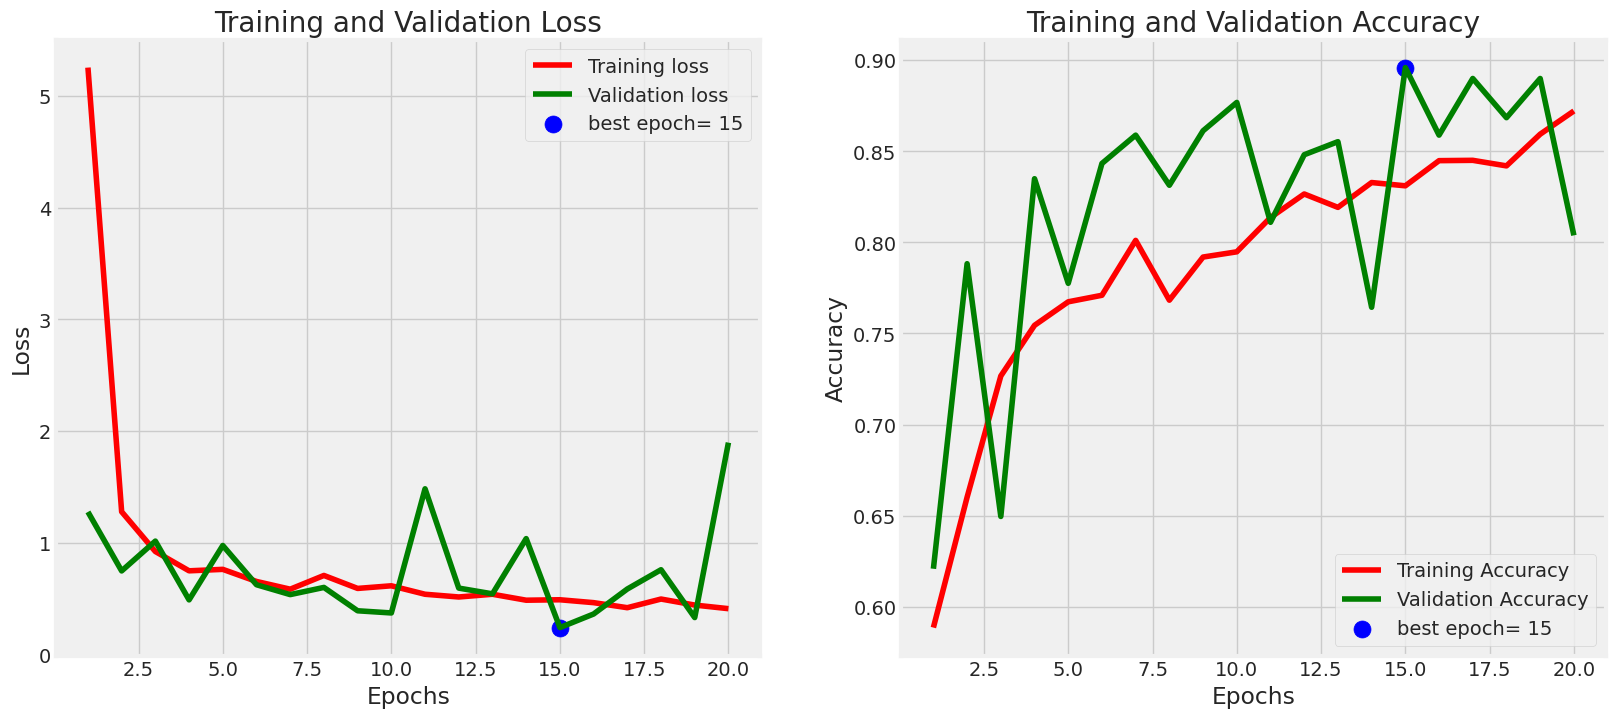

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

9/9 [==============================] - 33s 4s/step - loss: 2.5300 - accuracy: 0.7569
Train Loss:  1.1112971305847168
Train Accuracy:  0.8611111044883728
--------------------
Validation Loss:  3.9749205112457275
Validation Accuracy:  0.7430555820465088
--------------------
Test Loss:  2.529956102371216
Test Accuracy:  0.7569444179534912


## Classification Report from Predictions

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

    airplane       0.98      0.79      0.87        57
         car       0.95      1.00      0.97        75
         cat       0.84      0.23      0.36        69
         dog       0.56      0.40      0.46        58
      flower       0.42      1.00      0.59        64
       fruit       1.00      0.77      0.87        78
   motorbike       0.99      1.00      0.99        73
      person       0.98      0.99      0.98        84

    accuracy                           0.79       558
   macro avg       0.84      0.77      0.76       558
weighted avg       0.85      0.79      0.78       558



## Model Predictions for Each Natural Image Classification

In [ ]:
#Save the model
model.save('model.h5')

In [ ]:
loaded_model = tf.keras.models.load_model('/content/model.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

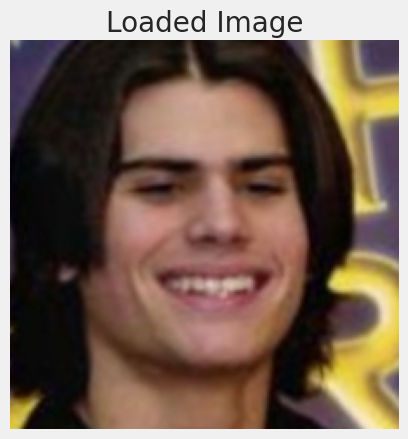

1/1 [==============================] - 0s 255ms/step
Predicted Class Label: person


In [ ]:
image_path = '/content/drive/MyDrive/ColabNotebooks/CECS456/FinalProject/project_images/natural_images/person/person_0001.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Display the image
plt.imshow(img)
plt.title("Loaded Image")
plt.axis('off')  # Hide axes ticks
plt.show()

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])

# Display prediction
predicted_class = class_labels[tf.argmax(score)]
print(f"Predicted Class Label: {predicted_class}")


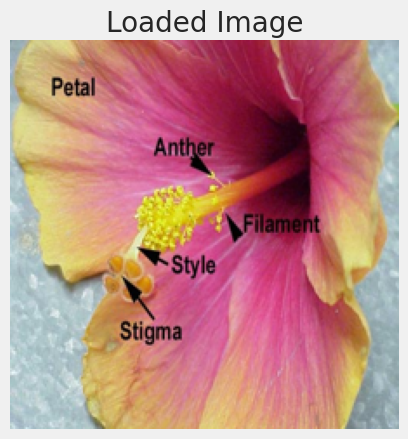

1/1 [==============================] - 0s 59ms/step
Predicted Class Label: flower


In [ ]:
image_path = '/content/drive/MyDrive/ColabNotebooks/CECS456/FinalProject/project_images/natural_images/flower/flower_0841.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Display the image
plt.imshow(img)
plt.title("Loaded Image")
plt.axis('off')  # Hide axes ticks
plt.show()

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])

# Display prediction
predicted_class = class_labels[tf.argmax(score)]
print(f"Predicted Class Label: {predicted_class}")

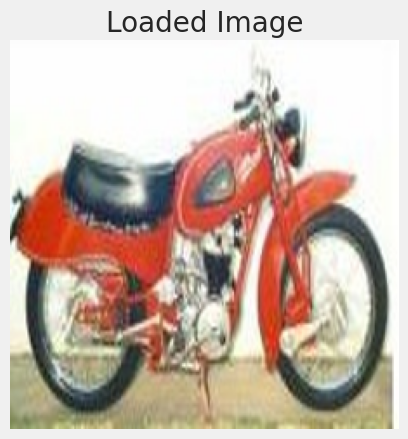

1/1 [==============================] - 0s 207ms/step
Predicted Class Label: motorbike


In [ ]:
image_path = '/content/drive/MyDrive/ColabNotebooks/CECS456/FinalProject/project_images/natural_images/motorbike/motorbike_0767.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Display the image
plt.imshow(img)
plt.title("Loaded Image")
plt.axis('off')  # Hide axes ticks
plt.show()

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])

# Display prediction
predicted_class = class_labels[tf.argmax(score)]
print(f"Predicted Class Label: {predicted_class}")

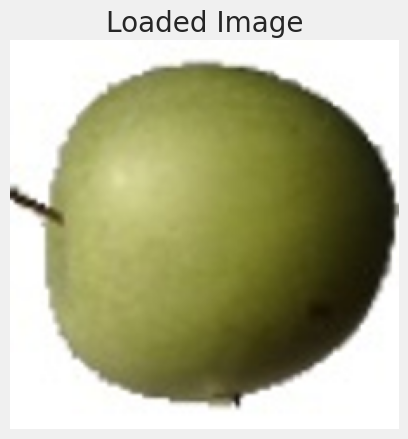

1/1 [==============================] - 0s 59ms/step
Predicted Class Label: fruit


In [ ]:
image_path = '/content/drive/MyDrive/ColabNotebooks/CECS456/FinalProject/project_images/natural_images/fruit/fruit_0555.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Display the image
plt.imshow(img)
plt.title("Loaded Image")
plt.axis('off')  # Hide axes ticks
plt.show()

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])

# Display prediction
predicted_class = class_labels[tf.argmax(score)]
print(f"Predicted Class Label: {predicted_class}")

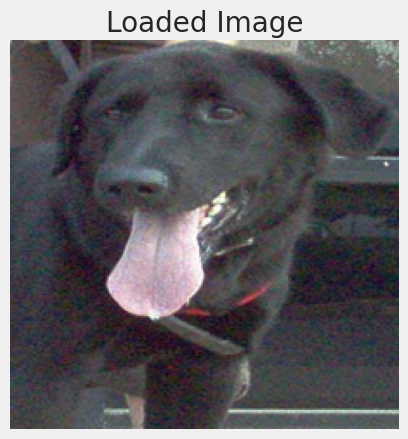

1/1 [==============================] - 0s 117ms/step
Predicted Class Label: dog


In [ ]:
image_path = '/content/drive/MyDrive/ColabNotebooks/CECS456/FinalProject/project_images/natural_images/dog/dog_0222.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Display the image
plt.imshow(img)
plt.title("Loaded Image")
plt.axis('off')  # Hide axes ticks
plt.show()

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])

# Display prediction
predicted_class = class_labels[tf.argmax(score)]
print(f"Predicted Class Label: {predicted_class}")

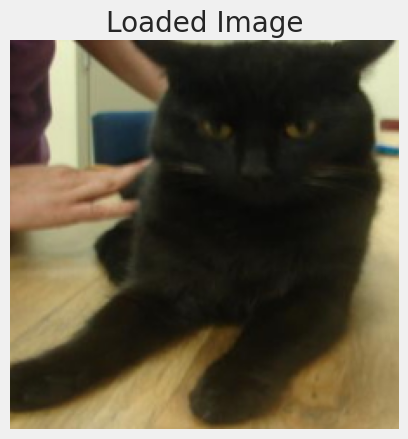

1/1 [==============================] - 0s 247ms/step
Predicted Class Label: cat


In [ ]:
image_path = '/content/drive/MyDrive/ColabNotebooks/CECS456/FinalProject/project_images/natural_images/cat/cat_0444.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Display the image
plt.imshow(img)
plt.title("Loaded Image")
plt.axis('off')  # Hide axes ticks
plt.show()

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])

# Display prediction
predicted_class = class_labels[tf.argmax(score)]
print(f"Predicted Class Label: {predicted_class}")

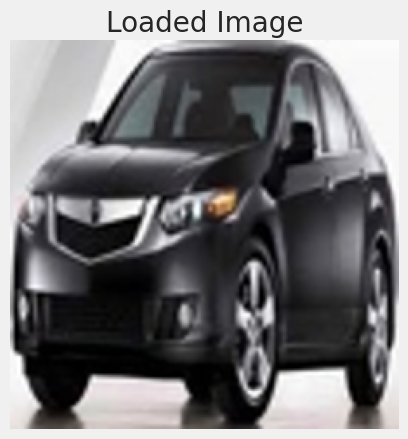

1/1 [==============================] - 0s 69ms/step
Predicted Class Label: car


In [ ]:
image_path = '/content/drive/MyDrive/ColabNotebooks/CECS456/FinalProject/project_images/natural_images/car/car_0222.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Display the image
plt.imshow(img)
plt.title("Loaded Image")
plt.axis('off')  # Hide axes ticks
plt.show()

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])

# Display prediction
predicted_class = class_labels[tf.argmax(score)]
print(f"Predicted Class Label: {predicted_class}")

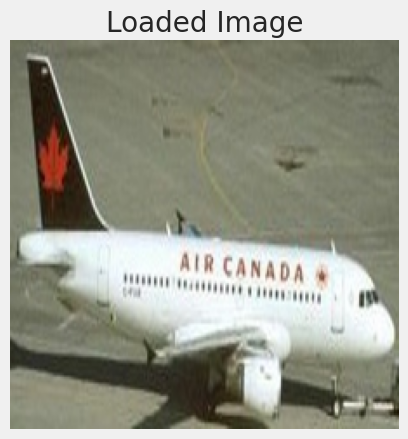

1/1 [==============================] - 0s 181ms/step
Predicted Class Label: airplane


In [ ]:
image_path = '/content/drive/MyDrive/ColabNotebooks/CECS456/FinalProject/project_images/natural_images/airplane/airplane_0333.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Display the image
plt.imshow(img)
plt.title("Loaded Image")
plt.axis('off')  # Hide axes ticks
plt.show()

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])

# Display prediction
predicted_class = class_labels[tf.argmax(score)]
print(f"Predicted Class Label: {predicted_class}")